# Face Generation

Jay Urbain  
jay.urbain@gmail.com

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

floyd run --gpu --data R5KrjnANiKVhLWAkpXhNBe --mode jupyter env=tensorflow-1.0

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

['/input/mnist/image_13119.jpg', '/input/mnist/image_32703.jpg', '/input/mnist/image_26142.jpg', '/input/mnist/image_58756.jpg', '/input/mnist/image_42180.jpg', '/input/mnist/image_21138.jpg', '/input/mnist/image_34161.jpg', '/input/mnist/image_9501.jpg', '/input/mnist/image_40722.jpg', '/input/mnist/image_18123.jpg', '/input/mnist/image_20409.jpg', '/input/mnist/image_33432.jpg', '/input/mnist/image_59485.jpg', '/input/mnist/image_5226.jpg', '/input/mnist/image_41451.jpg', '/input/mnist/image_25413.jpg', '/input/mnist/image_13830.jpg', '/input/mnist/image_52305.jpg', '/input/mnist/image_39883.jpg', '/input/mnist/image_1662.jpg', '/input/mnist/image_10284.jpg', '/input/mnist/image_42898.jpg', '/input/mnist/image_34879.jpg', '/input/mnist/image_53034.jpg', '/input/mnist/image_2391.jpg']


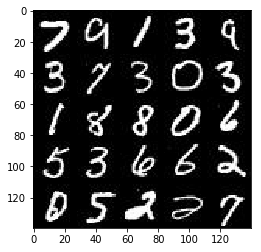

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
print(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images])
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

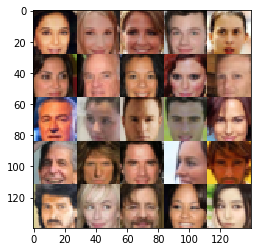

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))  
    Z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=(None))
    return input_images, Z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 4-layer convolution network

        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        lrelu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        # layer 2
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # layer 3
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=1, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256
        
        # Conv 4
        x4 = tf.layers.conv2d(lrelu3, 512, 5, strides=1, padding='SAME')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x512
        
        # flatten
        flat = tf.reshape(lrelu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Fully connected input layer connected
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512
        
        # Convolution transpose layers
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, strides=1, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, strides=2, padding='SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model                
    _, image_width, image_height, image_channels = data_shape
    
    # model_inputs: input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # model_loss: d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # model_opt: d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Batch counter
    batch_count = 0
    
    # Number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 6.3904
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 5.0142
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 30.8203
Epoch 1/2... Discriminator Loss: 3.1456... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 2.0165
Epoch 1/2... Discriminator Loss: 3.4573... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 2.5663... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 2.8913
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 2.7019
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 5.1749


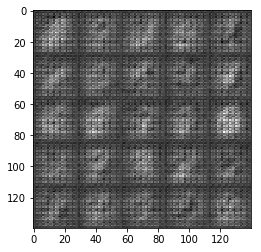

Epoch 1/2... Discriminator Loss: 3.1873... Generator Loss: 0.1171
Epoch 1/2... Discriminator Loss: 1.9031... Generator Loss: 5.3207
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 2.5060... Generator Loss: 5.7175
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 3.5349
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.8787
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.7068
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.9785
Epoch 1/2... Discriminator Loss: 2.6631... Generator Loss: 0.1766


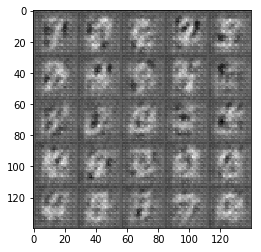

Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.7987
Epoch 1/2... Discriminator Loss: 1.6750... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 2.6503
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 2.6724
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 3.9421
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 4.1822
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 2.4582
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 2.9962
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 2.9558


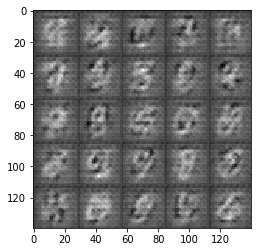

Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.5006
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.8301
Epoch 1/2... Discriminator Loss: 0.5314... Generator Loss: 2.7991
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 2.5098
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 2.1234
Epoch 1/2... Discriminator Loss: 0.4811... Generator Loss: 2.6119
Epoch 1/2... Discriminator Loss: 2.9575... Generator Loss: 0.1712


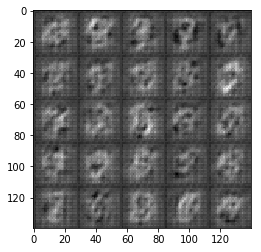

Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.5662
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 2.1291
Epoch 1/2... Discriminator Loss: 1.7893... Generator Loss: 4.2287
Epoch 1/2... Discriminator Loss: 1.6464... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 3.1118
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 1.6784
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.6325... Generator Loss: 1.7009
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.5226


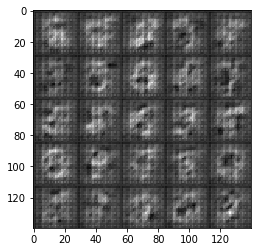

Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 2.8676
Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 1.8985
Epoch 1/2... Discriminator Loss: 2.3690... Generator Loss: 0.2460
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.6836
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 3.7077
Epoch 1/2... Discriminator Loss: 2.4931... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 3.1111... Generator Loss: 0.1684
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.3944


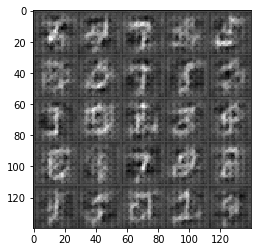

Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 2.1132
Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 3.1498
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 2.1432
Epoch 1/2... Discriminator Loss: 0.6351... Generator Loss: 1.6136
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 1.2212
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 2.8257
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 1.8846
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.1908


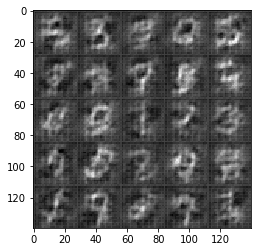

Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.6559
Epoch 1/2... Discriminator Loss: 1.8280... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 1.8223
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 1.7180
Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 2.7176
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.7966
Epoch 1/2... Discriminator Loss: 2.4339... Generator Loss: 0.3678
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 0.7679... Generator Loss: 1.7068
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 2.3880


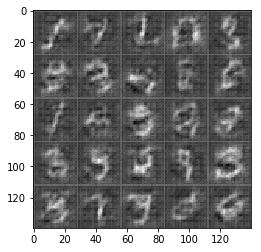

Epoch 1/2... Discriminator Loss: 2.3514... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.4898
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.6532
Epoch 1/2... Discriminator Loss: 2.7932... Generator Loss: 0.1902
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 2.1786
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 1.6234
Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 1.7253


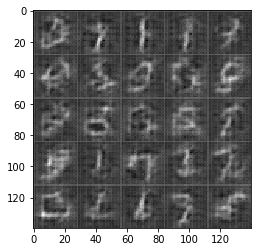

Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 1.9334
Epoch 1/2... Discriminator Loss: 2.3008... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 3.1631
Epoch 1/2... Discriminator Loss: 3.2152... Generator Loss: 0.1345
Epoch 1/2... Discriminator Loss: 1.9191... Generator Loss: 0.3952


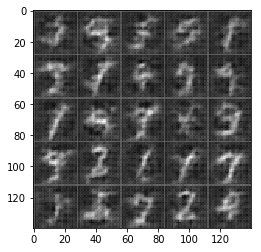

Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 5.0468
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.5788
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 2.5857... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 4.0385... Generator Loss: 0.0654


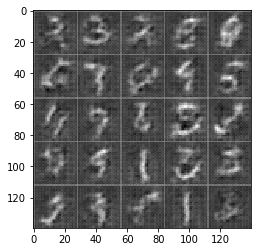

Epoch 1/2... Discriminator Loss: 2.1753... Generator Loss: 0.3177
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 2.4405
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 2.3405
Epoch 1/2... Discriminator Loss: 1.9496... Generator Loss: 3.4873
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 1.8141
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.8722


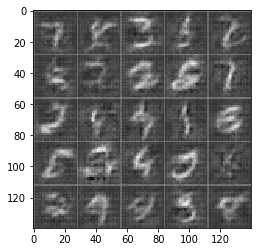

Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.8812... Generator Loss: 0.4046
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 3.1024
Epoch 1/2... Discriminator Loss: 1.7885... Generator Loss: 0.4442
Epoch 1/2... Discriminator Loss: 1.6311... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.5788... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.1946


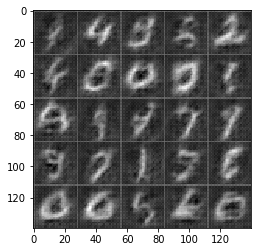

Epoch 1/2... Discriminator Loss: 2.2797... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 2.9320
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.4596
Epoch 1/2... Discriminator Loss: 2.7872... Generator Loss: 0.1512
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.6252
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 2.1959... Generator Loss: 0.2445
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 2.6739


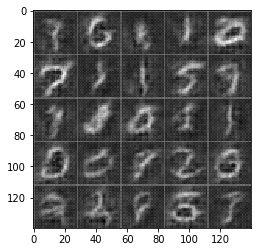

Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.8177... Generator Loss: 3.7195
Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 2.2447... Generator Loss: 0.2615
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 2.7511... Generator Loss: 0.1824
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6325
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 2.1736... Generator Loss: 0.3256
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.1404


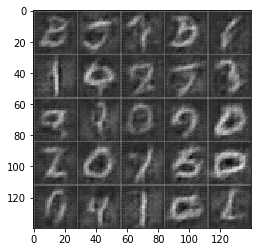

Epoch 1/2... Discriminator Loss: 2.2506... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 1.7724... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 1.8549
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 2.0651
Epoch 1/2... Discriminator Loss: 1.8565... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.7009


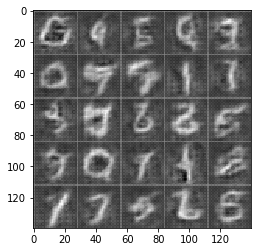

Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.5235
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 4.4118
Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.6103
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.5001
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 3.8402... Generator Loss: 0.0955
Epoch 1/2... Discriminator Loss: 2.1363... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.9827


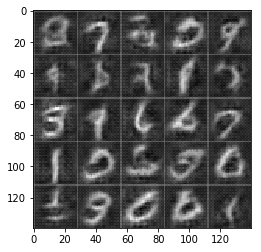

Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.6547
Epoch 1/2... Discriminator Loss: 2.7412... Generator Loss: 0.1796
Epoch 1/2... Discriminator Loss: 0.5652... Generator Loss: 1.9600
Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 2.1032... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 3.5517... Generator Loss: 0.0807
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 2.1500
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.1467


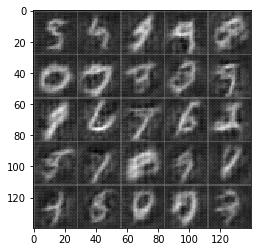

Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.6225
Epoch 1/2... Discriminator Loss: 3.1149... Generator Loss: 0.1271
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 4.6627
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.9517... Generator Loss: 0.3796
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.0363
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.2478
Epoch 2/2... Discriminator Loss: 1.6547... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.3626


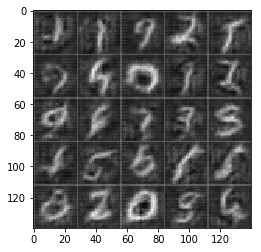

Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 2.0577
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 2.1179
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 3.5602
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.8038
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 2.9950
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.6850


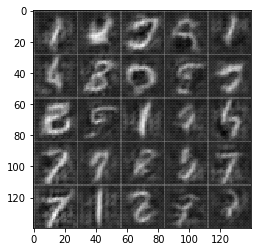

Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.7094
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 4.5806
Epoch 2/2... Discriminator Loss: 2.9800... Generator Loss: 0.1547
Epoch 2/2... Discriminator Loss: 2.5211... Generator Loss: 0.2844
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.1216


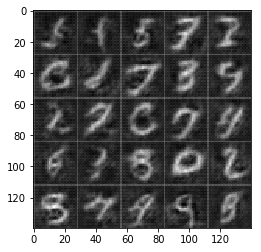

Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 1.0381
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.5748
Epoch 2/2... Discriminator Loss: 2.5973... Generator Loss: 0.1951
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.1291
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 3.0489
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 3.3682
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.8530


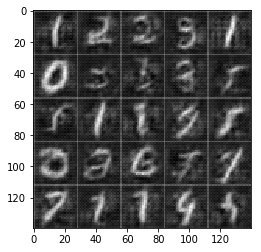

Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 1.0667
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 2.1440... Generator Loss: 0.3589
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 2.1089
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.4078
Epoch 2/2... Discriminator Loss: 1.5215... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 4.3240
Epoch 2/2... Discriminator Loss: 2.1239... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 1.5525


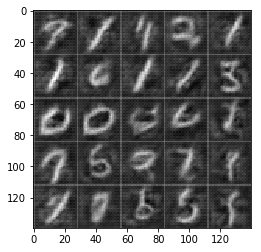

Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 1.5971
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.0929
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 2.3378... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 1.4172
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.1770
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.5469
Epoch 2/2... Discriminator Loss: 1.9515... Generator Loss: 0.3811


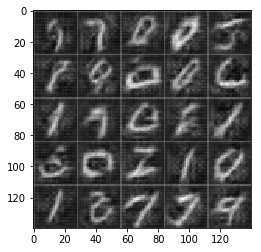

Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 2.0867
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 1.7287... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 1.9578... Generator Loss: 0.3185
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.5218
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 0.6027... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 2.1079... Generator Loss: 0.3842
Epoch 2/2... Discriminator Loss: 1.8791... Generator Loss: 0.3702


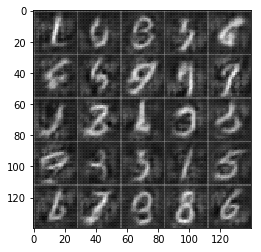

Epoch 2/2... Discriminator Loss: 2.1256... Generator Loss: 0.2572
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 3.1268
Epoch 2/2... Discriminator Loss: 1.6237... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.2101
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 1.0409
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 2.9429... Generator Loss: 0.1594


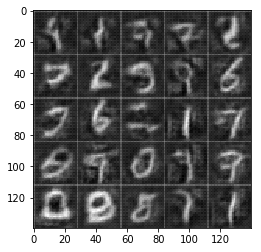

Epoch 2/2... Discriminator Loss: 2.0056... Generator Loss: 0.4234
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.9961
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.5927
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.5007
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 1.8158
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.4243
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.1406


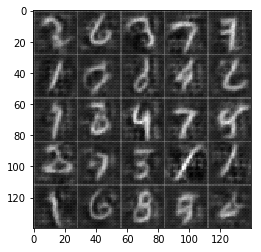

Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 4.3423... Generator Loss: 0.0769
Epoch 2/2... Discriminator Loss: 1.6388... Generator Loss: 3.5801
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 1.5103
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.2569


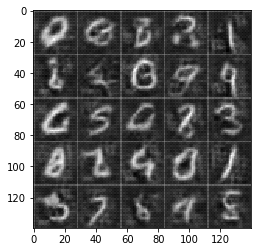

Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 3.5095
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.9660
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.3054
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.7326
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 2.1999
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.8446
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.9724


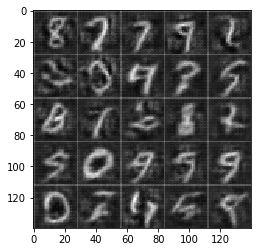

Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.9371
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.5104


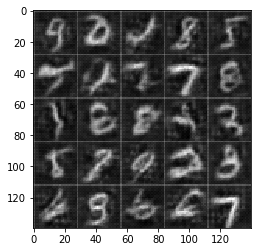

Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 1.7118... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.9429
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.8010
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 2.2711


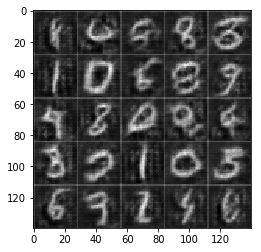

Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 2.0048... Generator Loss: 0.2937
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.9818
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 3.5477
Epoch 2/2... Discriminator Loss: 2.2288... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 2.0548
Epoch 2/2... Discriminator Loss: 1.7659... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.9105


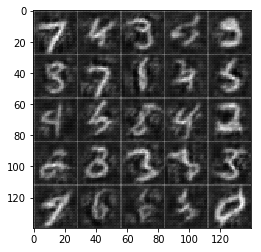

Epoch 2/2... Discriminator Loss: 2.1450... Generator Loss: 0.2768
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.2927
Epoch 2/2... Discriminator Loss: 2.4272... Generator Loss: 0.3311
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.8803
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 1.7487
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.7567


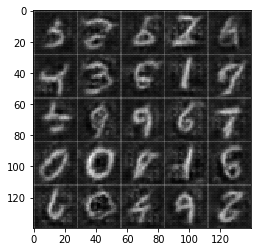

Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.7962
Epoch 2/2... Discriminator Loss: 1.4623... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.8007... Generator Loss: 0.3465
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 4.4416... Generator Loss: 0.0746
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.4060
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.6381


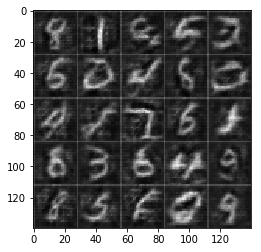

Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 2.2182
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 2.4739
Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 2.9432
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.1199
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.8783
Epoch 2/2... Discriminator Loss: 2.1473... Generator Loss: 0.2823
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 1.7107... Generator Loss: 0.4901


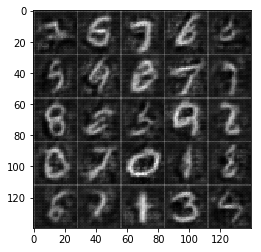

Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 2.6465... Generator Loss: 0.1764
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 1.9329... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 2.8149
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 2.2594


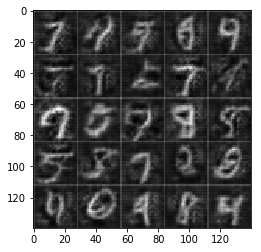

Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.2549
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.9050
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 2.8446
Epoch 2/2... Discriminator Loss: 1.7669... Generator Loss: 0.5364
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 0.9820
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.8950
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.8357


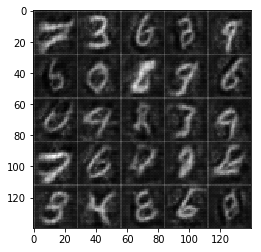

Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.2509


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.5995... Generator Loss: 0.0826
Epoch 1/1... Discriminator Loss: 2.0041... Generator Loss: 20.8772
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 1.9601... Generator Loss: 6.8903
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 4.8192
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 1.7259... Generator Loss: 4.8851
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 2.4559
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.0033


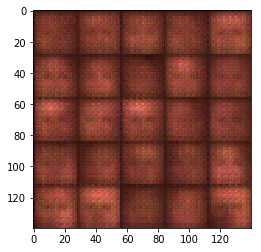

Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.5117
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 3.5946
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.5237
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 4.9007
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9131


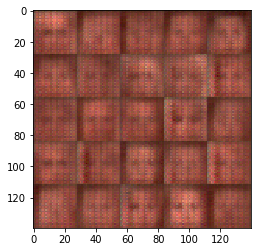

Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 2.1580... Generator Loss: 5.0829
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 2.1601
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.3087


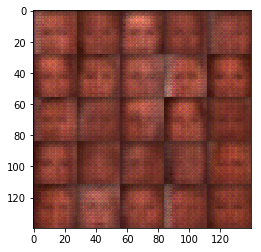

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 2.3630
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5781


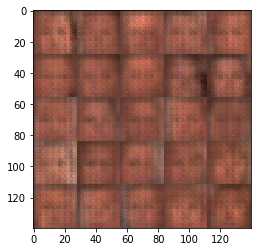

Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 2.8551
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.6721
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 2.0491
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.8086


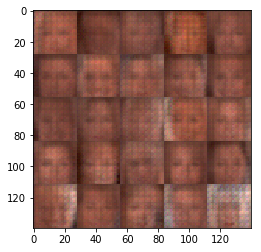

Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 2.0304... Generator Loss: 0.2679
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 1.7218... Generator Loss: 3.4740


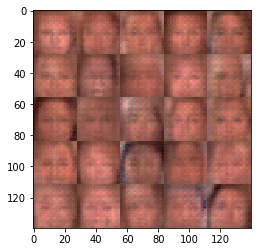

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.2775


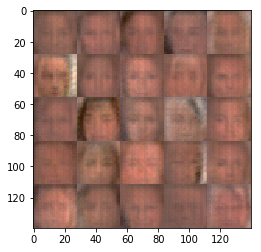

Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 2.0039... Generator Loss: 0.2692
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.4116
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8224


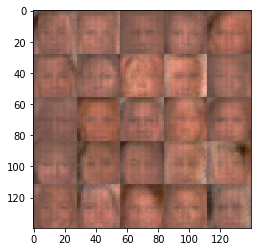

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 2.1891
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4015


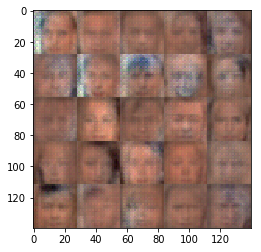

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 2.4705
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 2.5871
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.8417... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 2.2593... Generator Loss: 0.2121


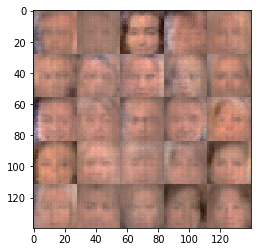

Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.4961


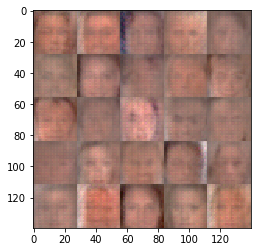

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.3625
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 2.8546
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.7248
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6897


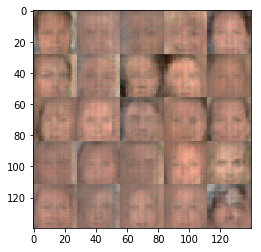

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 1.6467
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.1904


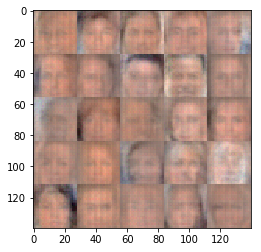

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.9122
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 2.0625
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8532


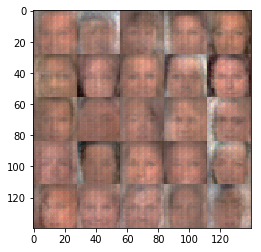

Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.1192


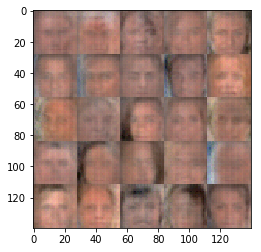

Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.9064... Generator Loss: 0.2989
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 2.6523
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1983


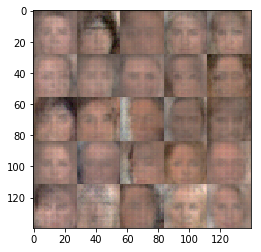

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 1.9502
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.9447
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5181


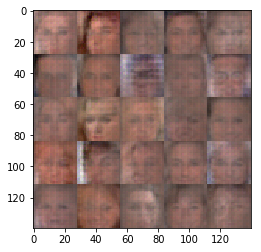

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.0449


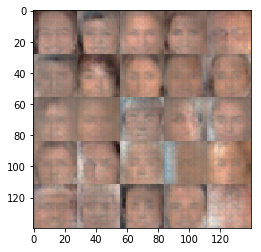

Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 3.3174
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 2.2392
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.6617


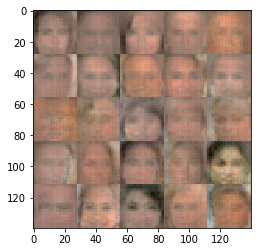

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.7545
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 2.3863
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.6322


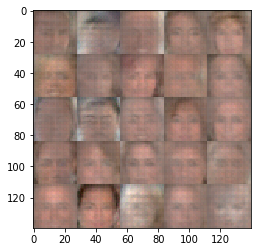

Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 2.0718
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.8696
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.9412


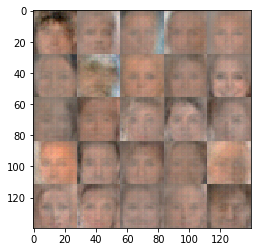

Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.8927
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 2.1109


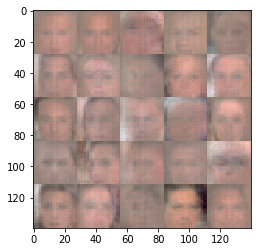

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 1.9992
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.9218... Generator Loss: 0.2931
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 1.9674
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.5596


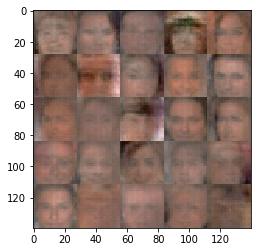

Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 2.9529
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.9387
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.8462
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 2.6215


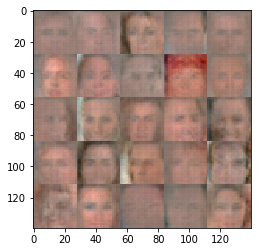

Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.6819


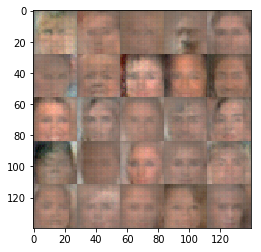

Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.8361... Generator Loss: 0.3290
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.8350... Generator Loss: 0.3258
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5799


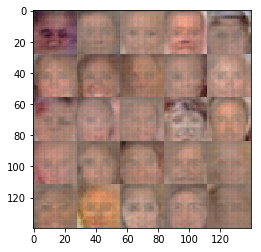

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 1.9546... Generator Loss: 0.2889
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 2.2245


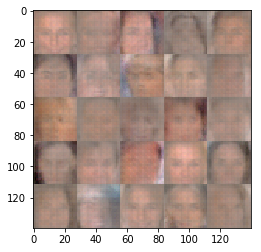

Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.8172


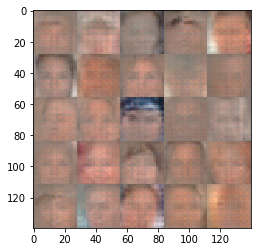

Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 2.2309
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.8149


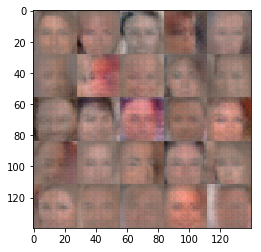

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 2.3457... Generator Loss: 0.1971
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.1127


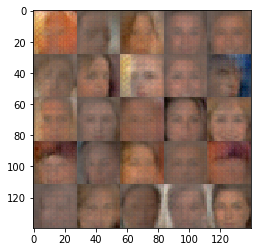

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 2.2895
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.6951... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 1.6201


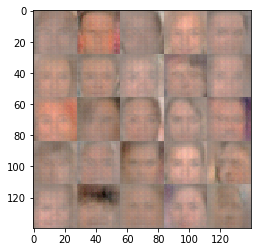

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8756


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.